In [1]:
pip install torchattacks

     |████████████████████████████████| 105 kB 12.2 MB/s 


In [2]:
pip install torchvision


In [3]:
pip install torch==1.7.1 torchvision==0.8.2 

     |████████████████████████████████| 776.8 MB 18 kB/s 
     |████████████████████████████████| 12.8 MB 23.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
#upload models.py file
from google.colab import files
uploaded = files.upload()

In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import PGD, FGSM

from models import CNN
import random
random.seed(42)

In [6]:
print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)

PyTorch 1.7.1
Torchvision 0.8.2
Torchattacks 3.2.6
Numpy 1.21.6


In [7]:
mnist_train = dsets.MNIST(root='./data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='./data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
type(mnist_train)

torchvision.datasets.mnist.MNIST

In [9]:
batch_size = 128

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=42)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=batch_size,
                                         shuffle=42)

In [10]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [11]:
model = CNN().cuda()

In [12]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
atk = PGD(model, eps=0.3, alpha=0.1, steps=7)

In [14]:
num_epochs = 5

In [15]:
for epoch in range(num_epochs):

    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = atk(batch_images, batch_labels).cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/5], lter [100/468], Loss: 2.2942
Epoch [1/5], lter [200/468], Loss: 2.0267
Epoch [1/5], lter [300/468], Loss: 1.8981
Epoch [1/5], lter [400/468], Loss: 1.8431
Epoch [2/5], lter [100/468], Loss: 1.5504
Epoch [2/5], lter [200/468], Loss: 1.4956
Epoch [2/5], lter [300/468], Loss: 1.4588
Epoch [2/5], lter [400/468], Loss: 1.3019
Epoch [3/5], lter [100/468], Loss: 1.0256
Epoch [3/5], lter [200/468], Loss: 0.9667
Epoch [3/5], lter [300/468], Loss: 0.9418
Epoch [3/5], lter [400/468], Loss: 0.8104
Epoch [4/5], lter [100/468], Loss: 0.8581
Epoch [4/5], lter [200/468], Loss: 0.8195
Epoch [4/5], lter [300/468], Loss: 0.6374
Epoch [4/5], lter [400/468], Loss: 0.6229
Epoch [5/5], lter [100/468], Loss: 0.6584
Epoch [5/5], lter [200/468], Loss: 0.4800
Epoch [5/5], lter [300/468], Loss: 0.6503
Epoch [5/5], lter [400/468], Loss: 0.7989


In [16]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Standard accuracy: %.2f %%' % (100 * float(correct) / total))

Standard accuracy: 93.65 %


In [17]:
model.eval()

correct = 0
total = 0

atk = FGSM(model, eps=0.3)

for images, labels in test_loader:
    
    images = atk(images, labels).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy FGSM Pixel MNIST: %.2f %%' % (100 * float(correct) / total))

Robust accuracy FGSM Pixel MNIST: 85.62 %


In [18]:
model.eval()

correct = 0
total = 0

atk = PGD(model, eps=0.3)

for images, labels in test_loader:
    
    images = atk(images, labels).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy PGD MNIST: %.2f %%' % (100 * float(correct) / total))

Robust accuracy PGD MNIST: 83.50 %


In [19]:
model.eval()
from torchattacks import FFGSM

correct = 0
total = 0

atk = FFGSM(model, eps=0.3)

for images, labels in test_loader:
    
    images = atk(images, labels).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy FFGSM MNIST: %.2f %%' % (100 * float(correct) / total))

Robust accuracy FFGSM MNIST: 92.13 %


In [20]:
pip install torch-dct

In [21]:
import torch
import torch_dct as dct

x = torch.randn(200)
print(x)
X = dct.dct(x)   # DCT-II done through the last dimension
print(X)




tensor([ 2.0286, -0.7716, -1.2547,  1.6710,  0.1884, -2.1759,  0.3126,  0.1385,
        -0.1640,  1.2114, -1.5451,  1.0651,  0.7288, -0.6766, -0.6003,  0.4501,
         0.7815, -0.0504,  1.0663, -2.1348,  0.3337,  0.6070, -1.0961,  0.9363,
        -1.2664,  1.0902,  2.1497, -0.4145,  0.1872,  1.4395,  0.3146,  0.2582,
        -0.6146, -1.3038,  0.7453, -1.2156,  0.9706, -2.2864, -0.8728, -1.0408,
        -0.2904,  0.9998, -0.3339, -0.0382,  1.0689, -1.8150, -0.0312,  0.1874,
         1.1686,  0.2474,  1.2161, -0.1774,  0.5617,  1.0953,  0.4275,  2.0657,
        -1.5601,  1.1904,  1.7654,  1.6157,  0.4801,  0.9300, -0.5711,  1.8483,
         1.8726, -0.5299, -0.7862, -0.7428, -0.1960, -0.4525, -1.9971, -1.6912,
        -0.1771, -0.0425,  1.2590,  0.8664, -0.8927,  0.7430,  0.2241,  1.1346,
        -0.8766, -0.7083,  2.0196,  1.6373,  0.9031, -0.1675, -0.1494, -0.0834,
         0.9195,  2.4888, -0.1676,  0.5071,  0.3880, -0.5185, -1.1135,  0.3353,
        -0.3537, -0.6261, -0.2179,  1.74

/usr/local/lib/python3.7/dist-packages/torch_dct/_dct.py:48: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  Vc = torch.rfft(v, 1, onesided=False)


In [22]:
for epoch in range(num_epochs):

    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        dct1 = dct.dct1(batch_images)
        X = atk(dct1, batch_labels).cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/5], lter [100/468], Loss: 0.8147
Epoch [1/5], lter [200/468], Loss: 0.6077
Epoch [1/5], lter [300/468], Loss: 0.4545
Epoch [1/5], lter [400/468], Loss: 0.3785
Epoch [2/5], lter [100/468], Loss: 0.3814
Epoch [2/5], lter [200/468], Loss: 0.3848
Epoch [2/5], lter [300/468], Loss: 0.2367
Epoch [2/5], lter [400/468], Loss: 0.2552
Epoch [3/5], lter [100/468], Loss: 0.1626
Epoch [3/5], lter [200/468], Loss: 0.2490
Epoch [3/5], lter [300/468], Loss: 0.1672
Epoch [3/5], lter [400/468], Loss: 0.2896
Epoch [4/5], lter [100/468], Loss: 0.2514
Epoch [4/5], lter [200/468], Loss: 0.1871
Epoch [4/5], lter [300/468], Loss: 0.2754
Epoch [4/5], lter [400/468], Loss: 0.1299
Epoch [5/5], lter [100/468], Loss: 0.1856
Epoch [5/5], lter [200/468], Loss: 0.1626
Epoch [5/5], lter [300/468], Loss: 0.2721
Epoch [5/5], lter [400/468], Loss: 0.0600


In [23]:
model.eval()
from torchattacks import FFGSM

correct = 0
total = 0

atk = FFGSM(model, eps=0.3)

for images, labels in test_loader:
    img =dct.dct1(images)
    
    images = atk(img, labels).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy FFGSM MNIST: %.2f %%' % (100 * float(correct) / total))

Robust accuracy FFGSM MNIST: 94.81 %


In [24]:
model.eval()

correct = 0
total = 0

atk = PGD(model, eps=0.3)

for images, labels in test_loader:
    img =dct.dct1(images)
    
    images = atk(img, labels).cuda()
    
    #images = atk(images, labels).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy PGD MNIST: %.2f %%' % (100 * float(correct) / total))

Robust accuracy PGD MNIST: 76.30 %


In [25]:
model.eval()

correct = 0
total = 0

atk = FGSM(model, eps=0.3)

for images, labels in test_loader:
    
    img =dct.dct1(images)
    
    images = atk(img, labels).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy FGSM MNIST on DCT: %.2f %%' % (100 * float(correct) / total))

Robust accuracy FGSM MNIST on DCT: 92.32 %


In [31]:
model.eval()

correct = 0
total = 0

atk = FGSM(model, eps=0.3)

for images, labels in test_loader:
    
    images = atk(images, labels).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy FGSM Pixel MNIST: %.2f %%' % (100 * float(correct) / total))

Robust accuracy FGSM Pixel MNIST: 0.62 %


In [26]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = (dct.dct1(images)).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Standard accuracy: %.2f %%' % (100 * float(correct) / total))

Standard accuracy: 68.97 %


In [27]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

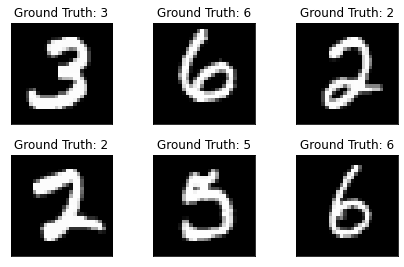

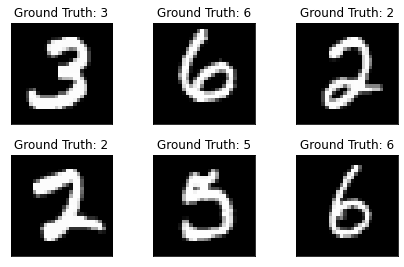

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

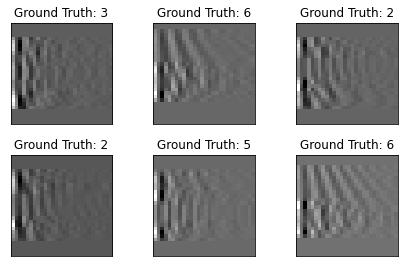

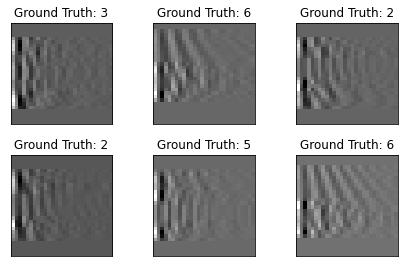

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow((dct.dct(example_data[i][0])), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig